- [1. Import Packages](#1)
- [2. Assembling Dataset](#2)
- [3. Model Training](#3)
  - [3.1 LSTM from Scratch](#3_1)
  - [3.2 Baseline Model from Article](#3_2)

## 1. Import Packages <a id='1'></a>

In [73]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler



## 2. Assembling Dataset <a id='2'></a>

In [76]:
all_features_path = '/Users/liqingyang/Documents/GitHub/variance_prediction/data/cleaned_data/btc_1d_engineered_selected_features.csv'
all_features = pd.read_csv(all_features_path)
all_features.columns

Index(['date', 'close', 'Volume BTC', 'Volume USD', '5_day_vol',
       'rsi_14_over_30', 'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol',
       'target'],
      dtype='object')

In [150]:
timesteps = 10
np.random.seed(0)
scaler = StandardScaler()
features = all_features[['close', 'Volume BTC', 'Volume USD', '5_day_vol',
       'rsi_14_over_30', 'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol']]
target = all_features['target'].to_numpy().reshape(-1, 1)
# target_scaled = scaler.fit_transform(target)


def create_sequences(target, timesteps):
    X, y = [], []
    for i in range(len(target) - timesteps):
        X.append(target[i:(i + timesteps)])
        y.append(target[i + timesteps])
    return np.array(X), np.array(y)


X, y = create_sequences(target, timesteps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)


## 3. Model Training <a id='3'></a>

### 3.1 LSTM from Scratch <a id='3_1'></a>

In [151]:
lstm = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1)),  
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [152]:
history = lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
test_loss = lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
predictions = lstm.predict(X_test)
# predictions_inverse = scaler.inverse_transform(predictions)
# y_test_inverse = scaler.inverse_transform(y_test)
# y_pred_inverse = scaler.inverse_transform(y_pred)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.0325e-04 - val_loss: 1.4046e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9906e-04 - val_loss: 1.1835e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7550e-04 - val_loss: 9.0981e-05
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5983e-04 - val_loss: 7.9975e-05
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1742e-04 - val_loss: 7.3787e-05
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1707e-04 - val_loss: 6.6776e-05
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0672e-04 - val_loss: 6.2527e-05
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8417e-05 - val_loss: 5.6350e-05
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6640e-05 - val_loss: 5.7576e-05
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1414e-05 - val_loss: 5.1905e-05
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2837e-05 - val_los

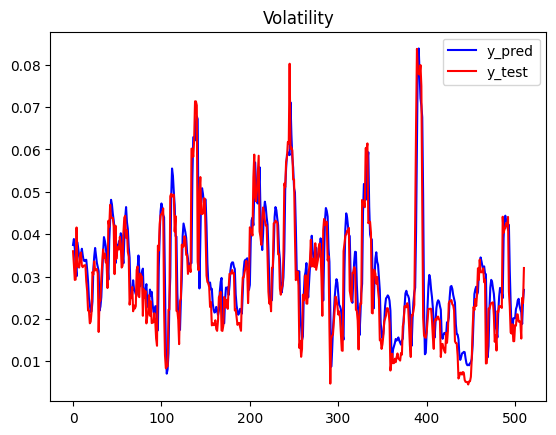

In [153]:
y_pred = pd.Series([i[0] for i in predictions])
y_test = pd.Series([i[0] for i in y_test])
_ = y_pred.plot(color='blue', label='y_pred')
_ = y_test.plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

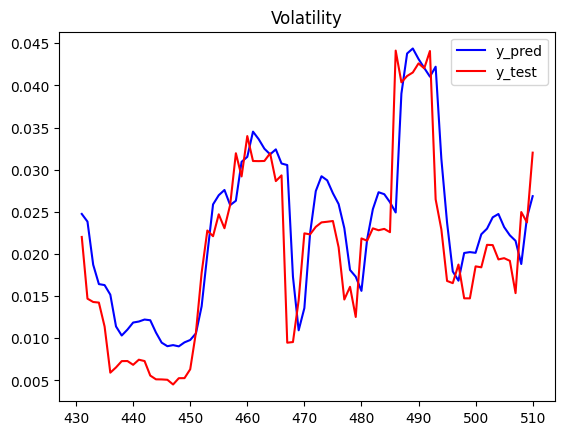

In [154]:
_ = y_pred.iloc[-80:].plot(color='blue', label='y_pred')
_ = y_test.iloc[-80:].plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

### 3.2 Baseline Model from Article <a id='3_2'></a>

In [155]:
def create_sequences_with_exogenous(features, target, timesteps):
    X, y = [], []
    for i in range(len(features) - timesteps):
        # Extracting the exogenous features for the past 'timesteps' and including the current timestep
        X.append(features[i:(i + timesteps)])  # '+1' to include current timestep features
        # The target is the value at the current timestep
        y.append(target[i + timesteps - 1])
    return np.array(X), np.array(y)

timesteps = 10
np.random.seed(0)
scaler = StandardScaler()
features = all_features[['close', 'Volume BTC', 'Volume USD', '5_day_vol',
       'rsi_14_over_30', 'rsi_7_over_14', 'vol_ratio_30_over_150', '7_day_vol']]
target = all_features['target'].to_numpy()
features_scaled = scaler.fit_transform(features)

X, y = create_sequences_with_exogenous(features_scaled, target, timesteps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)


In [156]:
X_train.shape

(2041, 10, 8)

In [157]:
lstm_enhanced = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  # Input shape is (10, 8)
    Dropout(rate=0.2),
    Dense(units=10, activation='relu'),
    GRU(units=50, return_sequences=False),  # Since it's followed by a Dense layer, return_sequences is False
    Dropout(rate=0.2),
    Dense(units=1)
])

lstm_enhanced.compile(optimizer='adam', loss='mse')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [158]:
history = lstm_enhanced.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
test_loss = lstm_enhanced.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
predictions_from_enhances = lstm_enhanced.predict(X_test)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0021 - val_loss: 1.3084e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7264e-04 - val_loss: 1.3651e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4359e-04 - val_loss: 1.3438e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6889e-04 - val_loss: 1.1853e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3397e-04 - val_loss: 1.0577e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7531e-04 - val_loss: 1.0722e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5643e-04 - val_loss: 1.2033e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7834e-04 - val_loss: 1.2264e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3835e-04 - val_loss: 9.6270e-05
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4583e-04 - val_loss: 9.4332e-05
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5034e-04 - val_

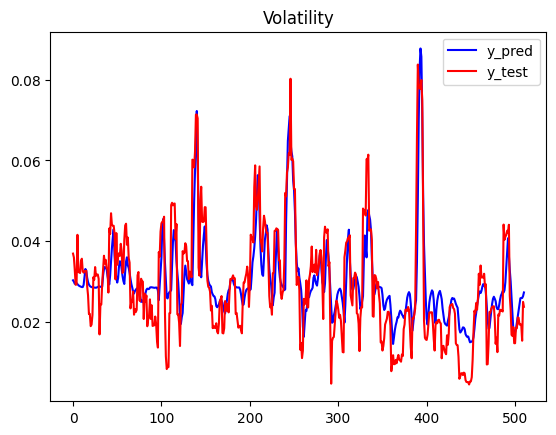

In [159]:
y_pred_from_enhanced = pd.Series([i[0] for i in predictions_from_enhances])
y_test_from_enhanced = pd.Series(y_test)
_ = y_pred_from_enhanced.plot(color='blue', label='y_pred')
_ = y_test_from_enhanced.plot(color='red', label='y_test')
_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()

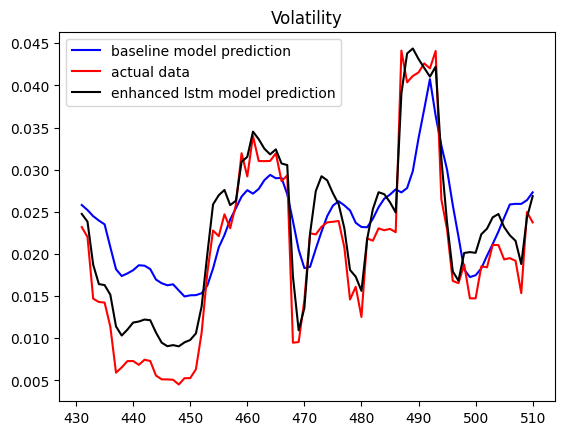

In [162]:
_ = y_pred_from_enhanced.iloc[-80:].plot(color='blue', label='baseline model prediction')
_ = y_test_from_enhanced.iloc[-80:].plot(color='red', label='actual data')
_ = y_pred.iloc[-80:].plot(color='black', label='enhanced lstm model prediction')

_ = plt.title("Volatility")
_ = plt.legend()
_ = plt.show()